In [68]:
import pandas as pd

train_raw = pd.read_csv('/kaggle/input/bytedatahack-22/train.csv')

In [69]:
train_raw = train_raw[train_raw['target'] != -1]

In [70]:
train_raw.loc[train_raw['description'].isnull(), 'description'] = train_raw[train_raw['description'].isnull()]['name']

In [71]:
train_raw['description'].iloc[0]

'<p><strong>Устал искать работу? Может, хочешь пиццу?<br />Тогда работай в Domino&#39;s!</strong></p> <p><strong><em>Что мы предлагаем ТЕБЕ:</em></strong></p> <ul> <li>почасовая оплата;</li> <li>ежемесячное премирование лучших сотрудников;</li> <li>дополнительный бонус к отпуску до 500 рублей;</li> <li>ПОЛНУЮ занятость (дневные и вечерние смены);</li> <li>обучим на рабочем месте с &quot;нуля&quot;;</li> <li>сертификация и повышение тарифной ставки через 6 месяцев;</li> <li>комфортную рабочую форму, средства индивидуальной защиты;</li> <li>возможность карьерного роста.</li> </ul> <p><strong><em>Что ТЫ будешь делать:</em></strong></p> <ul> <li>принимать и выдавать заказы, расчет с гостями;</li> <li>принимать выручку от водителей-курьеров;</li> <li>оформлять кассовые документы;</li> <li>производить инкассацию;</li> <li>готовить горячие напитки (кофе, чай).</li> </ul> <p><strong><em>Что мы ждём от ТЕБЯ:</em></strong></p> <ul> <li>желание обучиться работе с оборудованием и документацией;</l

In [72]:
import re
# as per recommendation from @freylis, compile once only
CLEANR = re.compile('<.*?>') 

def cleanhtml(raw_html):
  cleantext = re.sub(CLEANR, '', raw_html)
  return cleantext

In [73]:
train_raw['description'] = train_raw['description'].apply(cleanhtml)

In [74]:
train_raw['description'] = train_raw['description'].str.replace('\n', ' ')

In [118]:
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train, y_test = train_test_split(train_raw.drop('target', axis=1), train_raw['target'], train_size=.7)

In [119]:
from nltk.tokenize import word_tokenize

X_train = X_train_raw.copy()
X_test = X_test_raw.copy()
X_train['name'] = X_train_raw['name'].apply(lambda x: ' '.join(word_tokenize(str(x).lower(), language='russian')))
X_test['name'] = X_test_raw['name'].apply(lambda x: ' '.join(word_tokenize(str(x).lower(), language='russian')))
X_train['description'] = X_train_raw['description'].apply(lambda x: ' '.join(word_tokenize(str(x).lower(), language='russian')))
X_test['description'] = X_test_raw['description'].apply(lambda x: ' '.join(word_tokenize(str(x).lower(), language='russian')))


In [120]:
from collections import Counter

counter = Counter()

for i in pd.concat([X_train, X_test]).values:
    counter.update(i[1].split() + i[2].split())

In [121]:
counter.most_common(30)

[(',', 125043),
 ('и', 72886),
 ('.', 67657),
 (';', 62846),
 ('в', 52669),
 (':', 41644),
 ('с', 27698),
 ('на', 26162),
 ('работы', 25053),
 (')', 24349),
 ('(', 24201),
 ('по', 24059),
 ('-', 18631),
 ('опыт', 11486),
 ('от', 10809),
 ('&', 9919),
 ('работа', 9222),
 ('!', 9112),
 ('обязанности', 8809),
 ('для', 8399),
 ('за', 8113),
 ('к', 7667),
 ('условия', 7463),
 ('требования', 7091),
 ('не', 6692),
 ('до', 6452),
 ('график', 6139),
 ('мы', 5924),
 ('компании', 5873),
 ('контроль', 5447)]

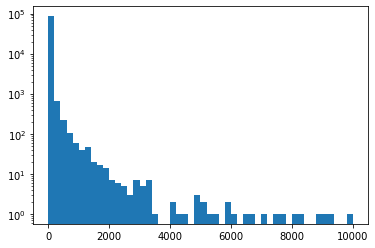

In [122]:
import matplotlib.pyplot as plt
plt.hist(list(counter.values()), range=[0, 10**4], bins=50, log=True);


In [123]:
min_count = 10
max_count = 6027
tokens = sorted([i[0] for i in counter.items() if min_count <= i[1] <= max_count])
n_vocab = len(tokens) + 2

UNK, PAD = '__UNK__', '__PAD__'
tokens = [UNK, PAD] + tokens

In [124]:
token2id = {t:i for i, t in enumerate(tokens)}

In [125]:
import numpy as np
UNK_IX, PAD_IX = map(token2id.get, [UNK, PAD])

def to_matrix(seq,max_len=None):
    if isinstance(seq.iloc[0], str):
        seq = list(map(str.split, seq))
    
    max_len = min(max(map(len, seq)), max_len or float('inf'))
    
    matrix = np.full((len(seq), max_len), PAD_IX)
    
    for i, sent in enumerate(seq):
        matrix[i, :len(sent)] = [token2id.get(token, UNK_IX) for token in sent]
    return matrix

to_matrix(X_train['name'][:2])

array([[ 1887, 11080],
       [ 5270,  8564]])

In [126]:
X_train['name'][:2]

5312        врач терапевт
1657    менеджер проектов
Name: name, dtype: object

In [127]:
import torch 

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def make_batch(df, target=None, device=device):
    res = {}
    res['name'] = torch.tensor(to_matrix(df['name']), device=device, dtype=torch.int64)
    res['description'] = torch.tensor(to_matrix(df['description']), device=device, dtype=torch.int64)
    if type(target) != type(None):
        res['target'] = torch.tensor(target, device=device, dtype=torch.int64)
    return res

make_batch(X_train.iloc[[0,3]], target=y_train.iloc[[0, 3]].values, device=device)

{'name': tensor([[ 1887, 11080],
         [ 1456,  4835]], device='cuda:0'),
 'description': tensor([[    0,     0,  6394,  5947,  7819,  7067,  8280,  7066,     0,  9695,
            973,     0,  6211,     0,  7926,  2653,     0,  5672,  4894,     0,
           4517, 12536,  4894,     0, 12385,  6570,  2356,     0,  4475,     0,
          10434,  9195,     0,  4517, 12536,  1873,  7063,     0,     0, 11222,
          12284,  8223,  9193,     0,  1598,     0,  9412,  7063,     0,     0,
              0,     0,     0,     0,  5044, 11465,  7791,  7318, 11585,  8870,
              0,  5232,  1004,     0, 11112,     0,     0,   372,  2728,  8915,
           5893,     0,   107,     0,   186,     0,  7324,  2172,     0,     0,
           6230,     0, 10167,     0,  1179,  7290,  6954,     0, 11161],
         [    0,  4339, 11325,  1458,  4835,     0,  1483,  5361,     0,  9184,
           3171,     0,  1572,  5937,  3750,  8118,  9756,  6489, 11359,  1928,
           1860,     0, 11048,  35

In [128]:
def iter_batches(df, target, batch_size=256, shuffle=True, device=device, **kwargs):
    while True:
        indices = np.arange(len(df))
        if shuffle:
            indices = np.random.permutation(indices)
        
        for start in range(0, len(indices), batch_size):
            batch = make_batch(df.iloc[indices[start:start+batch_size]], target=target[indices[start:start+batch_size]], device=device, **kwargs)
            yield batch
        break

In [129]:
okz = pd.read_csv('/kaggle/input/bytedatahack-22/okz_3_4_professions.csv', sep='	')
n_classes = len(okz['code'].unique())
okz

,code,control_number,profession,description
0,111,6.0,Руководители (представители) федеральных и рег...,Руководители\n(представители) федеральных и р...
1,1111,7.0,Руководители федеральных и региональных органо...,Руководители (представители) федеральных и ре...
2,1112,3.0,Руководители (представители) федеральных и рег...,\nРуководители (представители) федеральных и ...
3,1113,7.0,Руководители органов местного самоуправления,Руководители органов местного самоуправления ...
4,1114,0.0,Высшие должностные лица политических и обществ...,Высшие должностные лица политических\nи общес...
...,...,...,...,...
554,9621,9.0,"Посыльные, доставщики пакетов и багажа и подоб...","Посыльные, доставщики пакетов и\nбагажа и под..."
555,9622,2.0,Разнорабочие,"Разнорабочие чистят, окрашивают и\nпроводят т..."
556,9623,6.0,"Сборщики денег из торговых автоматов, контроле...","Сборщики денег из торговых автоматов, контрол..."
557,9624,8.0,Развозчики воды и сборщики дров,Развозчики воды и сборщики дров собирают воду...


In [130]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(okz['code'].values)

LabelEncoder()

In [131]:
y_train = le.transform(y_train.values)
y_test = le.transform(y_test.values)
# y_train.values

In [132]:
X_train.shape, y_train.shape

((10955, 3), (10955,))

In [133]:
y_test

array([285, 409, 409, ..., 386, 222, 553])

In [134]:
import torch.nn as nn 
import torch.nn.functional as F

class JobPredictor(nn.Module):
    def __init__(self, n_filters, n_hidden, emb_dim, n_tokens=n_vocab, n_classes=n_classes):
        super().__init__()
        self.desc = nn.Sequential(
            nn.Conv1d(emb_dim, n_filters, 3),
            nn.ReLU(),
            nn.AvgPool1d(3),
            nn.Conv1d(n_filters, n_filters, 3),
            nn.ReLU(),
            nn.AvgPool1d(3),
            nn.Conv1d(n_filters, n_filters, 3),
            nn.ReLU()
        )
        self.desc2 = nn.Sequential(
            nn.Conv1d(emb_dim, n_filters, 2),
            nn.ReLU(),
            nn.AvgPool1d(3),
            nn.Conv1d(n_filters, n_filters, 2),
            nn.ReLU(),
            nn.AvgPool1d(3),
            nn.Conv1d(n_filters, n_filters, 2),
            nn.ReLU()
        )
        self.name = nn.Sequential(
            nn.Conv1d(emb_dim, n_filters, 1),
            nn.ReLU(),
            nn.Conv1d(n_filters, n_filters, 1),
            nn.ReLU()
        )
        
        self.embeddings =nn.Embedding(n_tokens, emb_dim)
        self.avgpool_1 = nn.AdaptiveAvgPool1d(40)
        self.avgpool_2 = nn.AdaptiveAvgPool1d(30)
        self.avgpool_3 = nn.AdaptiveAvgPool1d(5)
        
        self.final = nn.Sequential(
            nn.Linear(225, n_hidden, dtype=torch.float64),
            nn.ReLU(),
            nn.BatchNorm1d(n_hidden, dtype=torch.float64),
            nn.Linear(n_hidden, n_classes, dtype=torch.float64)
        )
        
    def forward(self, x):
        name = x['name']
        name = self.embeddings(name).permute(0, -1, 1)
        name = self.name(name)
        name = self.avgpool_3(name)
        desc = x['description']
        desc = self.embeddings(desc).permute(0, -1, 1)
        desc2 = self.desc2(desc)
        desc = self.desc(desc)
        desc = self.avgpool_2(desc)
        desc2 = self.avgpool_1(desc2)
        final = torch.cat([name, desc, desc2], dim=-1).flatten(start_dim=1).double()
        return self.final(final.squeeze())

In [135]:
model = JobPredictor(3, 50, 100).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [136]:
from tqdm.notebook import tqdm, trange

def train_model(model, optimizer, criterion, train_set=X_train, train_target=y_train, epochs=10, **kwargs):
    lossi = []
    model.train()
    for _ in range(epochs):
        cum_loss = 0
        n_batches = 0
        for batch in tqdm(iter_batches(train_set, train_target, **kwargs)):
            preds = model(batch)
            loss = criterion(preds, batch['target'])
            cum_loss += loss.item()
            n_batches += 1
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        lossi.append(cum_loss/n_batches)
    return lossi

In [ ]:
lossi = train_model(model, optimizer, criterion)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
plt.plot(range(len(lossi)), lossi)

In [ ]:
from sklearn.metrics import accuracy_score

model.eval()
with torch.no_grad():
    accuracy = 0
    n_batches = 0
    for batch in tqdm(iter_batches(X_test, y_test)):
        logits = model(batch)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, 1).detach().cpu().numpy()
        accuracy += accuracy_score(preds, batch['target'].detach().cpu().numpy())
        n_batches += 1

print(f"Accuracy on test set: {accuracy/n_batches}")

In [110]:
model.eval()
with torch.no_grad():
    accuracy = 0
    n_batches = 0
    for batch in tqdm(iter_batches(X_train, y_train)):
        logits = model(batch)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1).detach().cpu().numpy()
        accuracy += accuracy_score(preds, batch['target'].detach().cpu().numpy())
        n_batches += 1

print(f"Accuracy on test set: {accuracy/n_batches}")

0it [00:00, ?it/s]

KeyError: 'target'

In [ ]:
test_raw = pd.read_csv('/kaggle/input/bytedatahack-22/test.csv')
test_raw.info()

In [101]:
test_raw['description'] = test_raw['description'].apply(cleanhtml)

In [102]:
test_raw['description'] = test_raw['description'].str.replace('\n', ' ')

In [103]:
test_raw['name'] = test_raw['name'].apply(lambda x: ' '.join(word_tokenize(str(x).lower(), language='russian')))
test_raw['description'] = test_raw['description'].apply(lambda x: ' '.join(word_tokenize(str(x).lower(), language='russian')))


In [104]:
test_raw.head()

,index,name,description
0,26461447,персональный водитель сервиса `` wheely ``,в связи с расширением автопарка объявляем набо...
1,26464220,менеджер по автоперевозкам,обязанности : поиск поставщиков ведение перево...
2,26467473,продавец кассир ( тц `` седанка сити `` ),твои обязанности : обслуживание покупателей в ...
3,26468989,специалист по кадрам,"обязанности : - оформление приема , перевода и..."
4,26471705,администратор на телефоне,обязанности : обработка входящих горячих заяво...


In [105]:
batch = make_batch(test_raw)

In [106]:
batch['name'].shape

torch.Size([1090, 16])

In [107]:
model.eval()
with torch.no_grad():
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1).detach().cpu().numpy() 

In [108]:
result = pd.DataFrame(dict(index=test_raw['index'], target=preds))

In [109]:
result.to_csv('submission.csv')